<a href="https://colab.research.google.com/github/imrealhelper/Linear-Algebra/blob/main/soft_ware_labs/ase3001_exercises_proportional_navigation_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proportional navigation in 3D space

<style>
.MathJax {
  font-family: "Common HTML";
}
</style>

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
\newcommand{\loss}{\ell}
\newcommand{\eloss}{\mc{L}}
\newcommand{\abs}[1]{| #1 |}
\newcommand{\norm}[1]{\| #1 \|}
\newcommand{\tp}{T}
$$

__<div style="text-align: right"> ASE3001: Computational Experiments for Aerospace Engineering, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_

<br>

Following the trajectory dispersion simulation of the free-flight rocket discussed in the previous example, we will address the rocket guidance problem of sending the rocket to a desired target. Correcting the trajectory by generating maneuver acceleration to move the vehicle to the desired target point is called _**guidance**_, and the guidance algorithm plays the role of periodically calculating appropriate maneuvering acceleration to move the vehicle to the target point using available information provided from navigation systems and sensors. The required maneuvering acceleration can be generated through normal forces such as lift produced by the vehicle’s angle of attack and side-slip angle.

<br>

---

<br>

First, let's revisit the simulation of the free-flight rocket's dynamic  model that incorporates the effects of wind.

<center>
<img src="https://jonghank.github.io/ase3001/files/frame.png" width="600">
</center>

The dynamics for the state variables that describe the direction of the rocket's velocity vector, namely the speed $V$, the vertical flight path angle $\gamma$, and the horizontal heading angle $\psi$, are given by,

$$
\begin{align*}
m\dot{V} &= D_x - mg\sin\gamma, \\
mV\dot{\gamma} &= -D_z - mg\cos\gamma, \\
mV\dot{\psi} &= D_y,
\end{align*}
$$

where the angles defined by,

- Vertical Flight Path Angle ( $\gamma$ ): Defined as  0  when flying horizontally. It increases when ascending, reaching  90 degrees  when flying vertically upward.
-	Horizontal Heading Angle ( $\psi$ ): Defined as  0  when flying due north. It increases when turning to the right, reaching  90 degrees when flying due east.

Parameters and variables are given by,

- $m$: The mass of the rocket.
- $D = (D_x, D_y, D_z) \in \R^3$: drag force components in the trajectory-tangential frame,
	- $D_x$ : Component in the direction of motion.
	- $D_y$ : Right horizontal component perpendicular to the direction of motion.
	- $D_z$ : Downward vertical component perpendicular to the direction of motion.
- $g$: The gravitational acceleration.

<br>

The rocket's position relative to the launch origin is expressed as  $p = (p_n, p_e, h) \in \R^3$, representing:

-	$p_n$ : Distance traveled in the north (N) direction.
-	$p_e$ : Distance traveled in the east (E) direction.
- $h$ : Altitude (H).

Note that the altitude direction (H) is opposite to the downward direction (D) where gravity acts. Also note that the gravitational acceleration varies with altitude as follows.

$$
	g(h) = g_0 \left(\frac{R_e}{R_e + h}\right)^2
$$

- $g_0$: Standard gravitational acceleration ($=9.80665\,\text{m/s}^2$)
- $R_e$: Earth's mean radius ($=6,378,137\,\text{m}$)

The rates of change of the position variables are given by:

$$
\begin{align*}
\dot{p}_n &= v_n = V\cos\gamma\cos\psi, \\
\dot{p}_e &= v_e = V\cos\gamma\sin\psi, \\
\dot{h} &= -v_d = V\sin\gamma,
\end{align*}
$$

where:

- $v_n$ : Northward component of the velocity.
- $v_e$ : Eastward component of the velocity.
- $v_d$ : Downward component of the velocity (with  $\dot{h} = -v_d$ ).

These equations express the NEH (North-East-Height) components of the velocity vector

<br>

The magnitude of the drag force is proportional to the dynamic pressure, as shown below. The dynamic pressure can be modeled as proportional to the atmospheric density, which is a function of altitude, and proportional to the square of the relative velocity with respect to the wind. The direction of the drag force is opposite to the relative velocity vector relative to the wind. The parameters  $C_d$  and  $S$  represent the rocket's drag coefficient and cross-sectional area, respectively, and are assumed to be constant. Combining these factors, the drag force components in the NED (North-East-Down) coordinate system,  $D_{\text{ned}} = (D_n, D_e, D_d)$ , can be calculated as follows:


\begin{align*}
  D_{ned} = \bmat{D_n \\ D_e \\ D_d} &=
  \overbrace{\overbrace{\frac{1}{2}\rho \|v_\text{rel} \|^2}^{\text{Dynamic pressure}}SC_d}^{\text{Magnitude of drag}}
  \overbrace{\left(-\frac{v_\text{rel}}{\|v_\text{rel} \|}\right)}^{\text{Direction of drag}} \\
  &= -\frac{1}{2}\rho SC_d \|v_\text{rel} \| v_\text{rel}
\end{align*}


The atmospheric density  $\rho(h)$  can be modeled as a function of altitude $h$  as follows. The units of density are in $\text{kg/m}^3$, and the units of altitude are in $\text{m}$:

$$
\rho(h) = \rho_0 \exp\left(-\frac{h}{H_s}\right)
$$

where:

-	$\rho_0$ is the atmospheric density at sea level (approximately $1.225\, \text{kg/m}^3$),
-	$H_s$ is the scale height, which is typically around $8,500\, \text{m}$ in the Earth's atmosphere,
-	$h$ is the altitude in meters.

This exponential model accounts for the decrease in atmospheric density with increasing altitude.


The rocket's relative velocity with respect to the wind ( $v_{\text{rel}} \in \R^3$ ) in the NED coordinate system can be expressed as:


\begin{align*}
  v_\text{rel} &= v_{\text{ned}}- v_{w} \\
  &= \bmat{V\cos\gamma\cos\psi \\ V\cos\gamma\sin\psi \\ -V\sin\gamma} - \bmat{v_{w,n} \\ v_{w,e} \\ v_{w,d}}
\end{align*}

<br>

Here:

- $V$  is the speed of the rocket.
- $\gamma$  is the vertical flight path angle.
- $\psi$  is the horizontal heading angle.
- $v_{\text{ned}}$  is the rocket's velocity in the NED coordinate system.
- $v_w = (v_{w,n}, v_{w,e}, v_{w,d})$ is the wind velocity in the NED coordinate system.

The drag force components  $D_{\text{ned}} = (D_n, D_e, D_d)$  calculated in the NED coordinate system can be transformed into the trajectory-tangential coordinate system drag components  $D_{xyz} = (D_x, D_y, D_z)$  through a rotation transformation. By computing these values at each moment using the state variables, the integration of the dynamics can be performed:


\begin{align*}
D_{xyz} = \begin{bmatrix} D_x \\ D_y \\ D_z \end{bmatrix} = \begin{bmatrix}
\cos\gamma \cos\psi & \cos\gamma \sin\psi & -\sin\gamma \\
-\sin\psi & \cos\psi & 0 \\
\sin\gamma \cos\psi & \sin\gamma \sin\psi & \cos\gamma
\end{bmatrix} D_{\text{ned}}
\end{align*}


In this transformation matrix:

-	The first row projects the NED components onto the direction of velocity.
-	The second row projects onto the right horizontal direction perpendicular to the direction of motion.
-	The third row projects onto the downward vertical direction perpendicular to the direction of motion.



<br>


Simulation parameters are set as follows:

- $m$ : Mass of the rocket ($=40\,\text{kg}$)
- $d$ : Diameter of the rocket ($=0.16\,\text{m}$)
- $S$ : Cross-sectional area of the rocket ($={\pi d^2}/{4}$)
- $C_d$ : Drag coefficient of the rocket ($=0.2$)
- $g$ : Gravitational acceleration ($=9.8\,\text{m/s}^2$)

These constants are used to calculate drag forces and the overall dynamics of the rocket throughout its trajectory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# parameters
m = 40               # mass
S = np.pi*0.08**2    # cross-section area
Cd = 0.2             # drag coefficient
g0 = 9.80665         # gravitational acceleration at sea level

# unit conversion
Rad2Deg = 180/np.pi  # conversion: radian to degree
Deg2Rad = 1/Rad2Deg  # conversion: degree to radian

np.random.seed(3001)

<br>

Wind is assumed to blow only horizontally, meaning there is no vertical component in the $h$- or $d$-direction. In the NED coordinate system, the wind velocity is expressed as $v_w = (v_{w,n}, v_{w,e}, 0)$.

- At the initial time step $k = 0$, the wind velocity components $v_{w,n}$ and $v_{w,e}$ follow a normal distribution with a mean of $0$ and a standard deviation of $5$. The vertical wind velocity component $v_{w,d} = 0$ is set to $0$ for all simulations.
- A random walk is applied to simulate wind speed changes at each time step $k$. The wind velocities are updated as follows, where $r_n$ and $r_e$ are random variables generated independently at each step, both following a normal distribution with a mean of $0$ and a standard deviation of $1$.

\begin{align*}
  v_{w,n}(t) &= v_{w,n}(t-\Delta t) + r_{n}(t) \\
  v_{w,e}(t) &= v_{w,e}(t-\Delta t) + r_{e}(t)
\end{align*}

<br>

---

By implementing the above modeling and performing numerical integration of the dynamics of a free-flying rocket launched to east with an initial flight path angle of 40 degrees and an initial velocity of 1 km/s, we can obtain results similar to those shown below. Observe that each time you run the simulation, different trajectories are obtained due to the random wind.

In [2]:
def state_derivative(z,v_w):
  V, gamma, psi, pn, pe, h = z

  rho = 1.225*np.exp(-h/8500)
  g = g0*(6378137/(6378137+h))**2

  c_gam, s_gam = np.cos(gamma), np.sin(gamma)
  c_psi, s_psi = np.cos(psi),   np.sin(psi)

  vn = V*c_gam*c_psi
  ve = V*c_gam*s_psi
  vd = -V*s_gam
  v_ned = np.array([vn, ve, vd])

  v_rel = v_ned - v_w
  v_mag = np.sqrt(v_rel.dot(v_rel))
  D_ned = -0.5*rho*S*Cd*v_mag*v_rel

  C_ned_to_xyz = np.array([[c_gam*c_psi,  c_gam*s_psi, -s_gam],
                           [     -s_psi,        c_psi,      0],
                           [s_gam*c_psi,  s_gam*s_psi,  c_gam]])
  D_xyz = C_ned_to_xyz.dot(D_ned)

  V_dot     =  D_xyz[0]/m   - g*s_gam
  gamma_dot = -D_xyz[2]/m/V - g*c_gam/V
  psi_dot   =  D_xyz[1]/m/V
  pn_dot = vn
  pe_dot = ve
  h_dot = -vd

  return np.array([V_dot, gamma_dot, psi_dot, pn_dot, pe_dot, h_dot])

In [3]:
# integration parameters
tf = 200                  # final time
dt = 0.1                  # step size
t = np.arange(0, tf, dt)  # time (tentative)
N = len(t)                # number of time steps

# initial conditions
V = 1000.0                # velocity
gamma = 40*Deg2Rad        # flight path angle
psi = 90*Deg2Rad          # heading
pn, pe, h = np.zeros(3)   # position
init = [V, gamma, psi, pn, pe, h]

In [4]:
# initialize time
t = np.arange(0, tf, dt)  # time (tentative)
N = len(t)                # number of time steps

# initial wind
v_w = 5*np.random.randn(3)
v_w[-1] = 0

# numerical integration
state = np.zeros((N,len(init)))
state[0] = init
deriv_p = state_derivative(state[0],v_w)
for k in range(N-1):
  deriv = state_derivative(state[k],v_w)
  state[k+1] = state[k] + dt*(3*deriv - deriv_p)/2
  v_w[0] += np.random.randn()
  v_w[1] += np.random.randn()
  deriv_p = deriv
  if state[k,-1]<0:       # termination condition
    break;                # break if the last state variable (h) is negative

# solution
t_s = t[:k+1]             # time
state = state[:k+1]       # state history

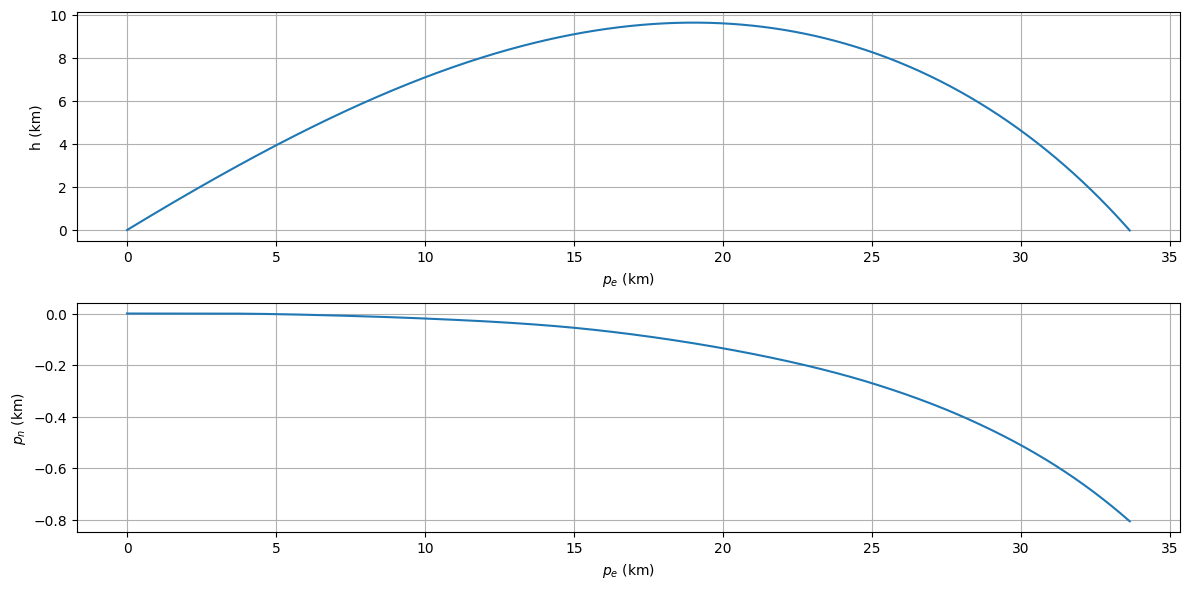

Impact velocity: 400.55 m/s
Impact angle: -57.35 deg
Flight range: 33.67 km


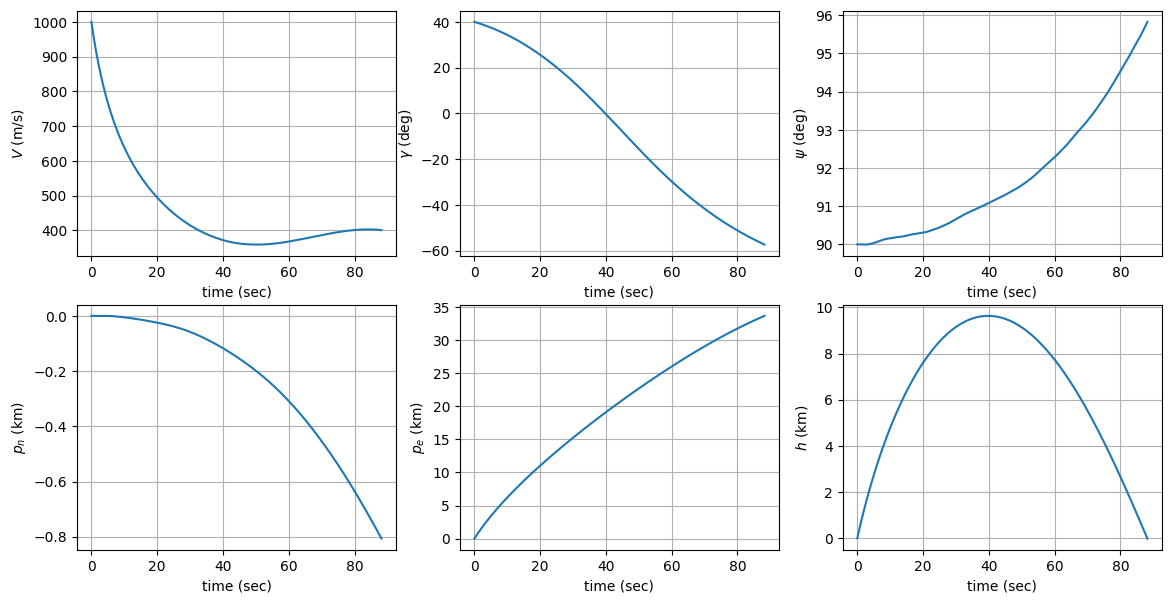

In [5]:
# plot
fig, ax = plt.subplots(2,1, figsize=(12,6), dpi=100)
ax[0].plot(state[:,4]/1000, state[:,5]/1000)
ax[0].set_xlabel(r'$p_e$ (km)')
ax[0].set_ylabel(r'h (km)')
ax[0].grid()
ax[1].plot(state[:,4]/1000, state[:,3]/1000)
ax[1].set_xlabel(r'$p_e$ (km)')
ax[1].set_ylabel(r'$p_n$ (km)')
ax[1].grid()
plt.tight_layout()
plt.show()

print(f'Impact velocity: {state[-1,0]:.2f} m/s')
print(f'Impact angle: {state[-1,1]*Rad2Deg:.2f} deg')


#?????????????????
print(f'Flight range: {np.linalg.norm(state[-1,3:5]/1000):.2f} km')

plt.figure(figsize=(14,7), dpi=100)
plt.subplot(2,3,1)
plt.plot(t_s, state[:,0])
plt.xlabel(r'time (sec)')
plt.ylabel(r'$V$ (m/s)')
plt.grid()
plt.subplot(2,3,2)
plt.plot(t_s, state[:,1]*180/np.pi)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$\gamma$ (deg)')
plt.grid()
plt.subplot(2,3,3)
plt.plot(t_s, state[:,2]*180/np.pi)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$\psi$ (deg)')
plt.grid()
plt.subplot(2,3,4)
plt.plot(t_s, state[:,3]/1000)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$p_n$ (km)')
plt.grid()
plt.subplot(2,3,5)
plt.plot(t_s, state[:,4]/1000)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$p_e$ (km)')
plt.grid()
plt.subplot(2,3,6)
plt.plot(t_s, state[:,5]/1000)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$h$ (km)')
plt.grid()
plt.show()

<br>

---

<br>

Now, let's examine the modeling of a guided rocket that includes guidance functionality. Note that there are two main differences compared to the modeling of the free-flight rocket without guidance functionality, as outlined below.

-	Inclusion of Maneuvering Accelerations:

  The maneuvering accelerations $u_z$ and $u_y$ serve to modify the trajectory in the vertical and horizontal directions, respectively. In practice, these accelerations are generated by aerodynamic forces (or control forces), which are the result of inner flight control loops that function by actuating control surfaces (e.g., fins or nozzles). In this context, we assume an ideal flight control, meaning that the maneuvering accelerations are generated instantaneously. The equations of motion are modified to include these accelerations as follows:

  \begin{align*}
  m\dot{V} &= D_x - m g \sin\gamma, \\
  m V \dot{\gamma} &= -D_z - m g \cos\gamma - m u_z, \\
  m V \dot{\psi} &= D_y + m u_y,
  \end{align*}

  where:
	- $m$  is the mass of the rocket.
	- $V$ is the speed of the rocket.
	- $\gamma$  is the vertical flight path angle.
	- $\psi$ is the horizontal heading angle.
	- $(D_x, D_y, D_z)$ are the components of the drag force in the trajectory-tangential coordinate system.
	- $g$ is the gravitational acceleration.
	- $u_z$ is the commanded maneuvering acceleration in the vertical plane.
	- $u_y$ is the commanded maneuvering acceleration in the horizontal plane.

-	Drag component induced by maneuver acceleration:

  Since the maneuvering accelerations for guidance are generated by the angle of attack ($\alpha$) and sideslip angle ($\beta$), the drag coefficient $C_d$ of the vehicle becomes a function of these two parameters. The greater the generated maneuvering force, the more the drag increases. The drag coefficient is modeled as:

  $$
  C_d = C_{d,0} + k_i \frac{4 m^2}{\rho^2 \| v_{\text{rel}} \|^4 S^2 C_{L,\alpha}^2} \left( u_z^2 + u_y^2 \right),
  $$

  where:
	- $C_{d,0}$ is the profile drag coefficient at zero angle of attack.
	- $k_i$ is the induced drag coefficient, representing the increase in drag due to maneuvering forces.
	- $m$ is the mass of the rocket.
	- $\rho$ is the atmospheric density.
	- $\| v_{\text{rel}} \|$  is the magnitude of the relative velocity between the rocket and the wind.
	- $S$ is the reference area (cross-sectional area) of the rocket.
	-	$C_{l,\alpha} = {\partial C_l}/{\partial \alpha}$ is the lift coefficient slope with respect to the angle of attack.
	- $u_z$  and $u_y$ are the maneuvering accelerations in the vertical and horizontal planes, respectively, with units of $\text{m}/\text{s}^2$.

  The first term  $C_{d,0}$  represents the baseline drag when there is no angle of attack or sideslip angle (i.e., the rocket is flying straight without maneuvering), and the second term accounts for the additional drag induced by maneuvering. As the rocket generates lift to maneuver, it also experiences an increase in drag, known as induced drag.

By incorporating these modifications, we can model the guided rocket's dynamics more accurately, accounting for the effects of maneuvering on both the trajectory and the aerodynamic forces. This sets the foundation for implementing guidance laws, such as proportional navigation, to direct the rocket toward a desired target while considering the trade-offs between maneuverability and aerodynamic efficiency.

<br>

Summarizing the simulation parameters with the newly defined parameters, we have:

- $m$ : Mass of the rocket ($=40\,\text{kg}$)
- $d$ : Diameter of the rocket ($=0.16\,\text{m}$)
- $S$ : Cross-sectional area of the rocket ($={\pi d^2}/{4}$)
- $g$ : Gravitational acceleration ($=9.8\,\text{m/s}^2$)
- $k_i$ : Induced drag coefficient ($=5$)
- $C_{d,0}$ : Profile drag coefficient at zero angle of attack ($=0.2$)
- $C_{l,\alpha}$ : Lift coefficient slope ($=8$)

These constants are essential for modeling the guided rocket's dynamics accurately. The newly introduced constants  $k_i$ ,  $C_{d,0}$ , and  $C_{l,\alpha}$  are particularly important for calculating the increased drag due to maneuvering accelerations as per the modified drag coefficient equation.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# parameters
m = 40               # mass
S = np.pi*0.08**2    # cross-section area
g = 9.8              # gravitational acceleration
ki = 5               # induced drag coefficient
Cd0 = 0.2            # profile drag coefficient
Cla = 8              # lift curve slope

# unit conversion
Rad2Deg = 180/np.pi  # conversion: radian to degree
Deg2Rad = 1/Rad2Deg  # conversion: degree to radian

<br>

---

<br>

_**(Problem 1)**_
Using the same definitions of state variables and wind modeling as in the previous cells, modify the function `state_derivative()` that calculates the time derivatives of the state variables for computing the trajectory of a rocket considering guidance functionality. The function should take as input the state variables $z_t$, wind velocity $v_w$, and guidance commands $u_t = (u_{t,z}, u_{t,y})$, and output the time derivatives $\dot{z}_t$ of the state variables. You may reuse most of the functions defined above, and clearly indicate the parts that have been modified.


In [7]:
def state_derivative(z,v_w,u):
  V, gamma, psi, pn, pe, h = z
  rho = 1.225*(1-2.256e-5*h)**5.256
  g = g0*(6378137/(6378137+h))**2

  c_gam, s_gam = np.cos(gamma), np.sin(gamma)
  c_psi, s_psi = np.cos(psi),   np.sin(psi)
  vn = V*c_gam*c_psi
  ve = V*c_gam*s_psi
  vd = -V*s_gam
  v_ned = np.array([vn, ve, vd])
  v_rel = v_ned - v_w
  v_mag = np.sqrt(v_rel.dot(v_rel))
  Cd = Cd0 + ki * (4 * m**2 / (rho**2 * S**2 * Cla**4)) * (u[0]**2 + u[1]**2) / v_mag**4
  D_ned = -0.5*rho*S*Cd*v_mag*v_rel
  C_ned_to_xyz = np.array([[c_gam*c_psi,  c_gam*s_psi, -s_gam],
                           [     -s_psi,        c_psi,      0],
                           [s_gam*c_psi,  s_gam*s_psi,  c_gam]])
  D_xyz = C_ned_to_xyz.dot(D_ned)
  V_dot    =  D_xyz[0]/m   - g*s_gam
  gamma_dot = -D_xyz[2]/(m*V) - g*c_gam/V -u[0]/V
  psi_dot   =  D_xyz[1]/(m*V) + u[1]/V
  pn_dot = vn
  pe_dot = ve
  h_dot = -vd


  ##################
  # your code here #


  # your code here #
  ##################

  return np.array([V_dot, gamma_dot, psi_dot, pn_dot, pe_dot, h_dot])

<br>

___

<br>

Proportional Navigation (PN) guidance, which is the most widely used guidance algorithm, is based on the principle that a target appearing to approach from the same direction will eventually collide with the interceptor.

PN guidance can be implemented in various ways depending on the vehicle system and available sensors. Here, we introduce the simplest method that can be applied in three-dimensional intercept scenarios.

<br>

Define the relative position and relative velocity of the target with respect to the rocket in the absolute coordinate system:

\begin{align*}
p_\text{r} &= p_\text{t} - p_\text{m}, \\
v_\text{r} &= v_\text{t} - v_\text{m}.
\end{align*}

Here, $p_\text{m}$ and $v_\text{m}$ represent the position and velocity (in the NED coordinate system) of the guided rocket, and $p_\text{t}$ and $v_\text{t}$ represent the position and velocity of the target. For a stationary target, $v_\text{t} = 0$.

<br>

The Line of Sight (LOS) vector $\lambda$, which represents the direction in which the target is seen, is equal to the relative position vector:

$$
\lambda = p_\text{r}.
$$

The rate of change of this LOS vector ($\dot\lambda$) has the following relationship with the relative position and relative velocity vectors:

$$
v_\text{r} = \dot\lambda \times p_\text{r}.
$$

By taking the cross product of both sides with  $p_\text{r}$ and simplifying, we get:

\begin{align*}
p_\text{r} \times v_\text{r} &= p_\text{r} \times \left( \dot\lambda \times p_\text{r} \right) \\
&= \dot\lambda \left( p_\text{r}^T p_\text{r} \right) - p_\text{r} \left( p_\text{r}^T \dot\lambda \right).
\end{align*}

Since the relative position and the LOS rate vector are perpendicular to each other ( $p_\text{r}^T \dot\lambda = 0$ ), we obtain the LOS rate vector as:

$$
\dot\lambda = \frac{p_\text{r} \times v_\text{r}}{\| p_\text{r} \|^2}.
$$

<br>

Proportional Navigation guidance generates the maneuver acceleration command proportional to the LOS rate, with the navigation constant $N$ (typically between 3 and 5) as follows:

$$
a_\text{cmd} = N v_\text{r}\times \dot\lambda.
$$

The trajectory-tangential $z$-axis and $y$-axis components of this commanded acceleration  $a_\text{cmd}$ correspond to $u_z$ and $u_y$.

The unit vector to the $y$-axis, denoted by $e_y$, can be obtained as the direction of the cross product of the gravity direction and $v_\text{m}$:

\begin{align*}
\tilde{e}_y &= \bmat{ 0 \\ 0 \\ 1 } \times v_\text{m}, \\
e_y &= \frac{ \tilde{e}_y }{ \| \tilde{e}_y \| }.
\end{align*}

Similarly, $e_z$, the unit vector to the $z$-axis, can be obtained as the direction of the cross product of $v_\text{m}$ and $e_y$:

\begin{align*}
\tilde{e}_z &= v_\text{m} \times e_y, \\
e_z &= \frac{ \tilde{e}_z }{ \| \tilde{e}_z \| }.
\end{align*}

Finally, using these, the $z$-axis and $y$-axis components of the commanded acceleration can be calculated as follows. Since a gravitational acceleration of $+g\cos\gamma$ acts in the $z$-axis direction, we compensate for the effect of gravity by adding $-\bar{g}\cos\gamma$ to the maneuvering acceleration in the $z$-direction, where  \bar{g}$ comes from the gravity model that the guidance computer uses.:

\begin{align*}
u_z &= e_z^T a_\text{cmd} - \bar{g}\cos\gamma, \\
u_y &= e_y^T a_\text{cmd}.
\end{align*}

<br>

However, since the rocket's maneuver acceleration is generated by normal forces such as lift, every rocket has a limit on the maneuver acceleration it can generate, and guidance commands should not generate maneuvering accelerations exceeding this limit. Let $u_\text{max}$ be this maximum maneuvering acceleration. If the magnitude of $u = (u_z, u_y)$  exceeds $u_\text{max}$, we can limit the magnitude of the maneuvering acceleration to $u_\text{max}$ using the following method:

\begin{align*}
u_z &= u_z \frac{u_\text{max}}{\sqrt{ u_z^2 + u_y^2 }}, \\
u_y &= u_y \frac{u_\text{max}}{\sqrt{ u_z^2 + u_y^2 }}.
\end{align*}

<br>

Lastly, immediately after launch, due to launch shocks, initial disturbances, and launch site safety considerations, it is common not to perform guidance immediately but to allow free flight for a certain period. Also, just before reaching the target, significant LOS rate changes can occur, so it is common not to perform guidance just before reaching the target.

-	Before $t_\text{start}$ after launch, let the rocket perform free flight:
  $$
  u = \bmat{u_z \\ u_y} = \bmat{0 \\ 0} \quad \text{if} \quad t < t_\text{start}.
  $$
-	When the remaining flight time $t_\text{go}$ becomes less than or equal to $t_\text{cutoff}$, set $a_\text{cmd} = 0$ to terminate guidance:
  $$
  u = \bmat{ u_z \\ u_y } = \bmat{ -\bar{g}\cos\gamma \\ 0 } \quad \text{if} \quad t_\text{go} < t_\text{cutoff}.
  $$

We estimate the remaining flight time ($t_\text{go}$) using a simple method as follows:

$$
t_\text{go} = \frac{ \| p_\text{r} \| }{ \| v_\text{r} \| }.
$$

<br>

___

<br>

_**(Problem 2)**_
Write a function `compute_guidance_cmd()` that takes as input the rocket's flight time, state variables, and the target's position and velocity, and computes the maneuvering acceleration command $u$ :

$$
u = \bmat{ u_z \\ u_y }
$$

<br>

You may use the following guidance parameters:

- $t_\text{start}$ : Time to end initial free flight and start guided flight ($=20\,\text{sec}$)
- $t_\text{cutoff}$ : Condition to terminate guided flight based on remaining flight time ($=1\,\text{sec}$)
- $u_\text{max}$ : Maximum allowable maneuver acceleration ($=10\,\text{m/s}^2$)
- $\bar{g}$ : Gravitational acceleration known to the guidance system ($=9.8\,\text{m/s}^2$)


In [66]:
def compute_guidance_cmd(t,state,p_target,v_target):

  V, gamma, psi, pn, pe, h = state
  g_bar = 9.8
  u_max = 10
  t_start = 20
  t_cutoff = 1
  if t < t_start:
    return np.array([0,0])
  else:
  ##################
  # your code here #
    p_m = np.array([pn, pe, -h])
    p_r = p_target - p_m
    rho = 1.225*(1-2.256e-5*h)**5.256
    c_gam, s_gam = np.cos(gamma), np.sin(gamma)
    c_psi, s_psi = np.cos(psi),   np.sin(psi)
    vn = V*c_gam*c_psi
    ve = V*c_gam*s_psi
    vd = -V*s_gam
    v_m= np.array([vn, ve, vd])
    v_r =  v_target - v_m
    Omega = np.cross(p_r, v_r) / np.linalg.norm(p_r)**2
    a_cmd = 3*np.cross(v_r, Omega)
    t_go = np.linalg.norm(p_r) / np.linalg.norm(v_r)
    if t_go < t_cutoff:
      a_cmd = np.zeros_like(a_cmd)

    e_sp_y = np.cross(np.array([0,0,1]),v_m)
    e_y = e_sp_y / np.linalg.norm(e_sp_y)
    e_sp_z = np.cross(v_m,e_y)
    e_z = e_sp_z/ np.linalg.norm(e_sp_z)
    u_z = np.dot(e_z,a_cmd) - g_bar*c_gam
    u_y = np.dot(e_y,a_cmd)
    u = np.array([u_z,u_y])
    if np.linalg.norm(u) > u_max:
        u = u * u_max / np.linalg.norm(u)
    return u

<br>

___

<br>

_**(Problem 3)**_
Using the guidance algorithm implemented in the function written above, guide the rocket to a target located 40 kilometers to the east. Examine the trajectory and state variables. Verify whether the rocket is appropriately guided near the target and report the miss distance (how close the rocket impacts the target).

In [67]:
# integration parameters
tf = 200                  # final time
dt = 0.1                  # step size
t = np.arange(0, tf, dt)  # time (tentative)
N = len(t)                # number of time steps

# initial conditions
V = 1000.0                # velocity
gamma = 40*Deg2Rad        # flight path angle
psi = 90*Deg2Rad          # heading
pn, pe, h = np.zeros(3)   # position
init = [V, gamma, psi, pn, pe, h]

In [68]:
# target position
p_target = np.array([0,40000,0])
v_target = np.array([0,0,0])

##################
# your code here #



# your code here #
##################

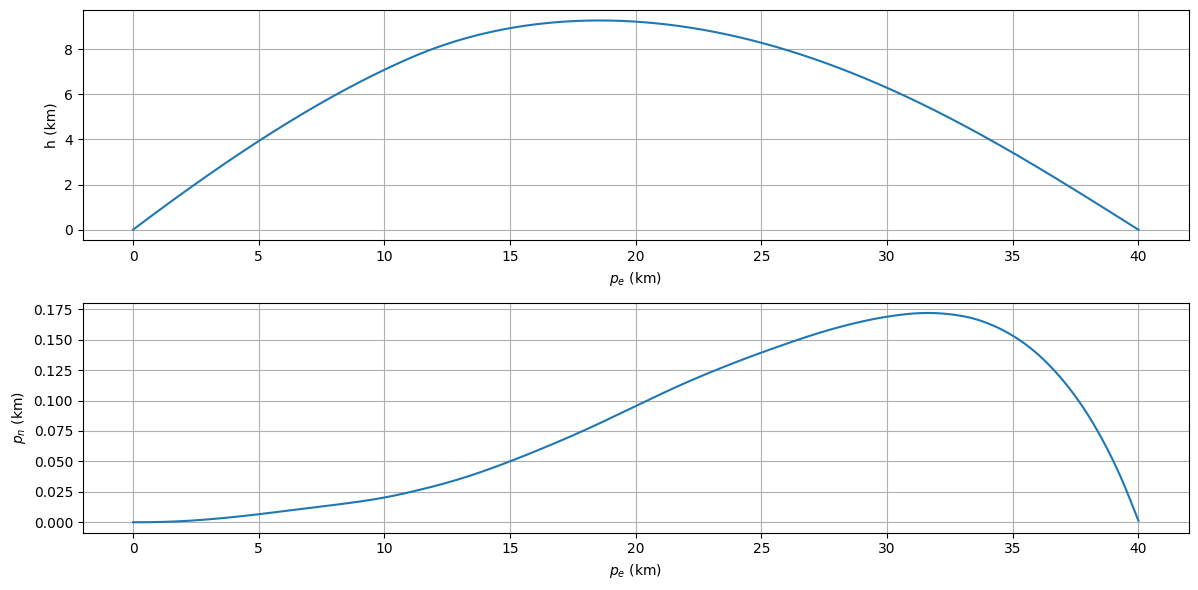

Impact velocity:: 353.74 m/s
Impact angle: -35.05 deg
Flight range: 40.01 km
Impact point (N): 0.00125 km
Impact point (E): 40.00546 km


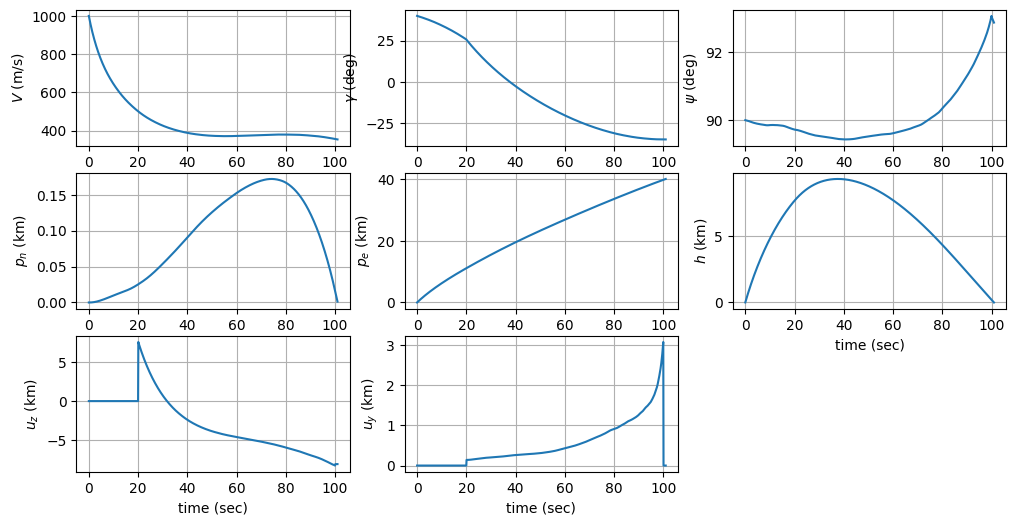

In [72]:
# initialize time
t = np.arange(0, tf, dt)
N = len(t)
# initial wind

v_w = 5*np.random.randn(3)
v_w[-1] = 0

state = np.zeros((N,len(init)))
state[0] = init
u = compute_guidance_cmd(t[0],state[0],p_target,v_target)
deriv_p = state_derivative(state[0],v_w,u)
U = np.zeros((N,len(u)))
U[0] = u
for k in range(N-1):
  u = compute_guidance_cmd(t[k],state[k],p_target,v_target)
  U[k+1] = u
  deriv = state_derivative(state[k],v_w,u)
  state[k+1] = state[k] + dt*(3*deriv - deriv_p)/2
  v_w[0] += np.random.randn()
  v_w[1] += np.random.randn()
  deriv_p = deriv
  if state[k,-1]<0:
    break;


t_s = t[:k+1]
state = state[:k+1]
U = U[:k+1]

fig, ax = plt.subplots(2,1, figsize=(12,6), dpi=100)
ax[0].plot(state[:,4]/1000, state[:,5]/1000)
ax[0].set_xlabel(r'$p_e$ (km)')
ax[0].set_ylabel(r'h (km)')
ax[0].grid()
ax[1].plot(state[:,4]/1000, state[:,3]/1000)
ax[1].set_xlabel(r'$p_e$ (km)')
ax[1].set_ylabel(r'$p_n$ (km)')
ax[1].grid()
plt.tight_layout()
plt.show()

print(f'Impact velocity:: {state[-1,0]:.2f} m/s')
print(f'Impact angle: {state[-1,1]*Rad2Deg:.2f} deg')
print(f'Flight range: {np.linalg.norm(state[-1,3:5]/1000):.2f} km')
print(f'Impact point (N): {state[-1,3]/1000:.5f} km')
print(f'Impact point (E): {state[-1,4]/1000:.5f} km')

plt.figure(figsize=(12,6), dpi=100)
plt.subplot(3,3,1)
plt.plot(t_s, state[:,0])
plt.xlabel(r'time (sec)')
plt.ylabel(r'$V$ (m/s)')
plt.grid()
plt.subplot(3,3,2)
plt.plot(t_s, state[:,1]*180/np.pi)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$\gamma$ (deg)')
plt.grid()
plt.subplot(3,3,3)
plt.plot(t_s, state[:,2]*180/np.pi)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$\psi$ (deg)')
plt.grid()
plt.subplot(3,3,4)
plt.plot(t_s, state[:,3]/1000)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$p_n$ (km)')
plt.grid()
plt.subplot(3,3,5)
plt.plot(t_s, state[:,4]/1000)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$p_e$ (km)')
plt.grid()
plt.subplot(3,3,6)
plt.plot(t_s, state[:,5]/1000)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$h$ (km)')
plt.grid()
plt.subplot(3,3,7)
plt.plot(t_s, U[:,0])
plt.xlabel(r'time (sec)')
plt.ylabel(r'$u_z$ (km)')
plt.grid()
plt.subplot(3,3,8)
plt.plot(t_s, U[:,1])
plt.xlabel(r'time (sec)')
plt.ylabel(r'$u_y$ (km)')
plt.grid()
plt.show()

<br>

___

<br>

_**(Problem 4)**_
Perform 2000 Monte-Carlo simulations and plot all 2000 trajectories on a single plane.


In [12]:
# integration parameters
tf = 200                  # final time
dt = 0.1                  # step size
t = np.arange(0, tf, dt)  # time (tentative)
N = len(t)                # number of time steps

# initial conditions
V = 1000.0                # velocity
gamma = 40*Deg2Rad        # flight path angle
psi = 90*Deg2Rad          # heading
pn, pe, h = np.zeros(3)   # position
init = [V, gamma, psi, pn, pe, h]

# Monte-Carlo simulation parameter
n_mc = 2000               # number of Monte-Carlo runs

100 200 300 400 500 600 700 800 900 1000
1100 1200 1300 1400 1500 1600 1700 1800 1900 2000


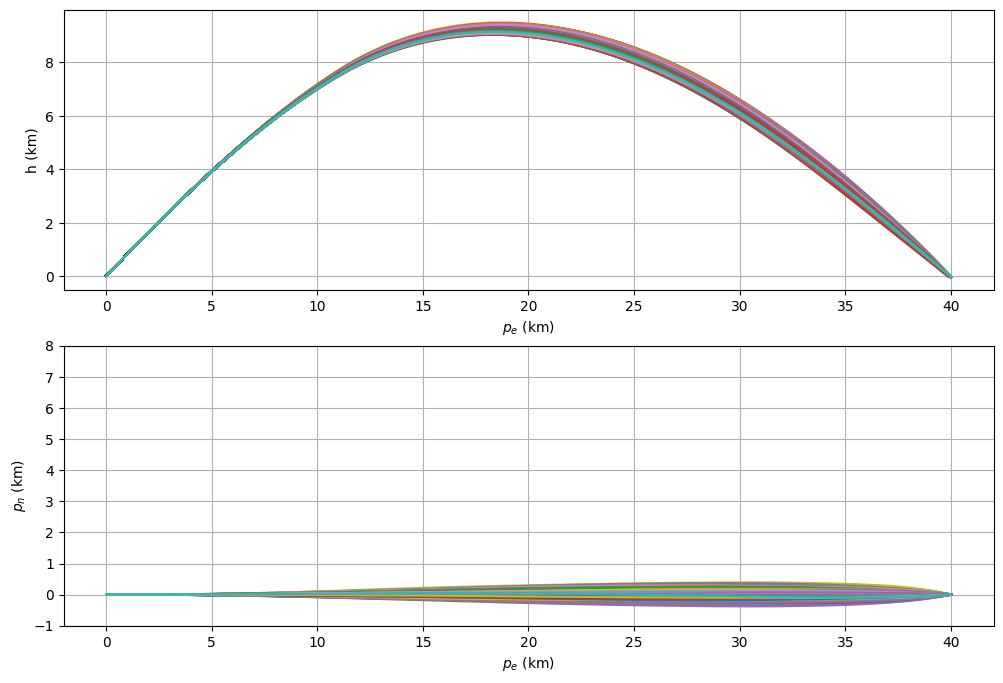

In [19]:
##################
# your code here #
import time
# integration parameters
tf = 200                  # final time
dt = 0.1                  # step size
t = np.arange(0, tf, dt)  # time (tentative)
N = len(t)                # number of time steps

# initial conditions
V = 1000.0                # velocity
gamma = 40*Deg2Rad        # flight path angle
psi = 90*Deg2Rad          # heading
pn, pe, h = np.zeros(3)   # position
init = [V, gamma, psi, pn, pe, h]

# Monte-Carlo simulation parameter
n_mc = 2000               # number of Monte-Carlo runs



def simulate(i):
  t = np.arange(0, tf, dt)
  N = len(t)
  np.random.seed(i)
  v_w = 5*np.random.randn(3)
  v_w[-1] = 0
  state = np.zeros((N,len(init)))
  state[0] = init
  u = compute_guidance_cmd(t[0],state[0],p_target,v_target)
  deriv_p = state_derivative(state[0],v_w,u)
  for k in range(N-1):
    u = compute_guidance_cmd(t[k],state[k],p_target,v_target)
    deriv = state_derivative(state[k],v_w,u)
    state[k+1] = state[k] + dt*(3*deriv - deriv_p)/2
    np.random.seed(i * k + k + i + int(time.time() * 1000) % 2 + int(time.time()%100))
    v_w[0] += np.random.randn()
    v_w[1] += np.random.randn()
    v_w[2] += np.random.randn()
    deriv_p = deriv
    if state[k,-1]<0:
      break;
  t_s = t[:k+1]
  state = state[:k+1]
  return state
States = {i:0 for i in range(n_mc)}
plt.figure(figsize = [12,8])
for i in range(1,n_mc+1):
  state = simulate(i)
  States[i] = state
  if i%100 == 0:
    if i %1000!=0:
      print(i,end = " ")
    else:
      print(i)
  plt.subplot(2,1,1)
  plt.plot(state[:,4]/1000, state[:,5]/1000)
  plt.subplot(2,1,2)

  plt.plot(state[:,4]/1000, state[:,3]/1000)
  plt.ylim([-1,8])
plt.subplot(2,1,1)
plt.grid()
plt.xlabel(r'$p_e$ (km)')
plt.ylabel(r'h (km)')
plt.subplot(2,1,2)
plt.grid()
plt.xlabel(r'$p_e$ (km)')
plt.ylabel(r'$p_n$ (km)')
plt.show()


# your code here #
##################

<br>

___

<br>

_**(Problem 5)**_
Using the results from the 2000 Monte-Carlo runs, plot the impact points on the NE (North-East) plane using the `scatter()` function from `matplotlib.pyplot`, and also plot the positions of the target and the average impact point.

The accuracy of guided rockets is typically expressed in terms of CEP (Circular Error Probable), which is defined as the radius of a circle centered on the target within which there is a 50% probability of impact. In other words, if a guided rocket has a CEP of 200 meters, it means that out of 100 launches, approximately 50 rockets will land within 200 meters of the target center.

Using the above calculation results, estimate the CEP of this guided rocket.


CEP는 14.431853737564728m 입니다.


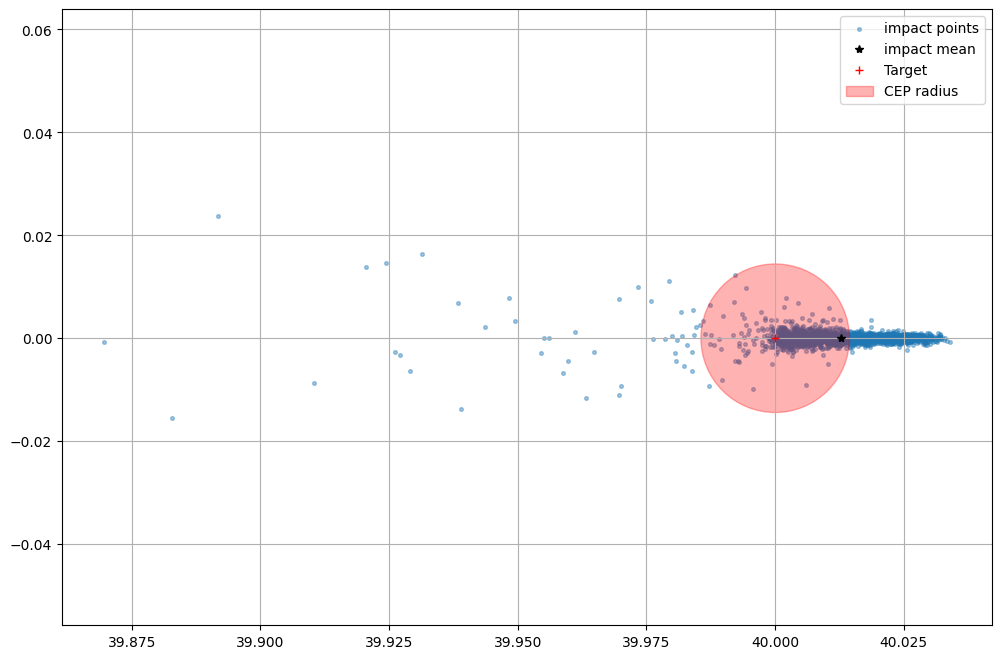

In [21]:
impact_points = np.zeros((n_mc,2))
CEPS = np.zeros(n_mc)
for i in range(n_mc):
  a = States[i+1]
  impact_point = a[-1,3:5]
  impact_points[i] = impact_point
  CEPS[i] = np.linalg.norm(impact_point/1000 - np.array([0,40]))
CEPS = sorted(CEPS)
r_cep = CEPS[len(CEPS)//2]
number = 0
for i in range(n_mc):
  a = States[i+1]
  impact_point = a[-1,3:5]
  if np.linalg.norm(impact_point/1000 - np.array([0,40])) < r_cep:
    number +=1

if number == n_mc//2:
  print(f"CEP는 {1000*r_cep}m 입니다.")
  plt.figure(figsize = [12,8])
  plt.scatter(impact_points[:,1]/1000, impact_points[:,0]/1000, alpha = 0.4,s=7,label ="impact points")
  plt.plot(np.mean(impact_points[:,1]/1000), np.mean(impact_points[:,0]/1000),"*",color ="black",label ="impact mean")
  plt.plot(40,0,"+",color ="red",label ="Target")
  circle = plt.Circle(np.array([40,0]), r_cep, color='r', alpha=0.3, fill=True, label="CEP radius")
  plt.gca().add_artist(circle)
  plt.axis('equal')
  plt.grid()
  plt.legend()
  plt.show()